In [1]:
# !pip3 install --no-cache-dir --upgrade --force-reinstall tensorflow==1.14 #tensorflow-gpu
# !pip3 install --no-cache-dir tensor2tensor
# !pip3 install --no-cache-dir bblfsh

In [1]:
#@title Run this only once - Sets up TF Eager execution.
import tensorflow as tf

# t2t supports only TF 1.14 ATM
print(tf.__version__)

# Enable Eager execution - useful for seeing the generated data.
tf.enable_eager_execution()

# Set a seed so that we have deterministic outputs.
from tensor2tensor.utils import trainer_lib
RANDOM_SEED = 301
trainer_lib.set_random_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

1.14.0
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.








# Function name suggestion

Given the _function body_ text, suggest a _function name_.

Use existing multi-lingual dataset of ~3m functions from Github CodeSearchNet (500k Java).

Q: best way to compare results:
 - \w identifier-based predictions?
 - \w literature

## Data: exploration

In [5]:
from pathlib import Path

java_files = sorted(Path('/devfest/repos/name-suggestion/tmp/java/').glob('**/*.gz'))
print(f'Total number of files: {len(java_files):,}')

columns_long_list = ['repo', 'path', 'url', 'code', 
                     'code_tokens', 'func_name', 
                     'language', 'partition']

def jsonl_list_to_dataframe(file_list, columns=columns_long_list):
    """Load a list of jsonl.gz files into a pandas DataFrame."""
    return pd.concat([pd.read_json(f, 
                                   orient='records', 
                                   compression='gzip',
                                   lines=True)[columns] 
                      for f in file_list], sort=False)


Total number of files: 18


In [6]:
jdf = jsonl_list_to_dataframe(java_files)

In [20]:
jdf.head(3)

,repo,path,url,code,code_tokens,func_name,language,partition
0,ReactiveX/RxJava,src/main/java/io/reactivex/internal/observers/...,https://github.com/ReactiveX/RxJava/blob/ac841...,protected final void fastPathOrderedEmit(U val...,"[protected, final, void, fastPathOrderedEmit, ...",QueueDrainObserver.fastPathOrderedEmit,java,test
1,ReactiveX/RxJava,src/main/java/io/reactivex/Observable.java,https://github.com/ReactiveX/RxJava/blob/ac841...,@CheckReturnValue\n @NonNull\n @Schedule...,"[@, CheckReturnValue, @, NonNull, @, Scheduler...",Observable.amb,java,test
2,ReactiveX/RxJava,src/main/java/io/reactivex/Observable.java,https://github.com/ReactiveX/RxJava/blob/ac841...,"@SuppressWarnings(""unchecked"")\n @CheckRetu...","[@, SuppressWarnings, (, ""unchecked"", ), @, Ch...",Observable.ambArray,java,test


In [81]:
# with pd.option_context('display.max_colwidth', -1):
#     display(jdf.code_tokens.head(3))

0    [protected, final, void, fastPathOrderedEmit, (, U, value, ,, boolean, delayError, ,, Disposable, disposable, ), {, final, Observer, <, ?, super, V, >, observer, =, downstream, ;, final, SimplePlainQueue, <, U, >, q, =, queue, ;, if, (, wip, ., get, (, ), ==, 0, &&, wip, ., compareAndSet, (, 0, ,, 1, ), ), {, if, (, q, ., isEmpty, (, ), ), {, accept, (, observer, ,, value, ), ;, if, (, leave, (, -, 1, ), ==, 0, ), {, return, ;, }, }, else, {, q, ., offer, (, value, ), ;, }, }, else, {, q, ...]                                                                                  
1    [@, CheckReturnValue, @, NonNull, @, SchedulerSupport, (, SchedulerSupport, ., NONE, ), public, static, <, T, >, Observable, <, T, >, amb, (, Iterable, <, ?, extends, ObservableSource, <, ?, extends, T, >, >, sources, ), {, ObjectHelper, ., requireNonNull, (, sources, ,, "sources is null", ), ;, return, RxJavaPlugins, ., onAssembly, (, new, ObservableAmb, <, T, >, (, null, ,, sources, ), ), ;, }]          

In [74]:
jdf.partition.value_counts()

train    454451
test      26909
valid     15328
Name: partition, dtype: int64

In [21]:
jdf['code_len'] = jdf.code_tokens.apply(lambda x: len(x))
jdf['func_name_len'] = jdf.func_name.apply(lambda x: len(x))
jdf['func_name_splits'] = jdf.func_name.apply(lambda x: len(x.split('.')))

In [72]:
# func_name, chars
func_name_len_summary = jdf['func_name_len'].quantile([.5, .7, .8, .9, .95, 1])
display(pd.DataFrame(func_name_len_summary))

,func_name_len
0.50,29.0
0.70,35.0
0.80,39.0
0.90,46.0
0.95,51.0
1.00,140.0


In [16]:
str.find?

In [75]:
# code_len, tokens
code_len_summary = jdf['code_len'].quantile([.5, .7, .8, .9, .95, 1])
display(pd.DataFrame(code_len_summary))

,code_len
0.50,66.0
0.70,104.0
0.80,142.0
0.90,224.0
0.95,331.0
1.00,68278.0


In [ ]:
!pip3 install matplotlib

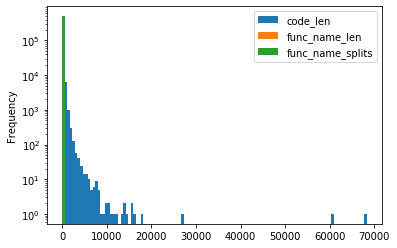

In [28]:
jdf.plot.hist(by='code_len', bins=120, log = True)

In [73]:
jdf.groupby(['partition', 'language'])['code_tokens'].count()

partition  language
test       java         26909
train      java        454451
valid      java         15328
Name: code_tokens, dtype: int64

In [35]:
# dataset outlier analysis
with pd.option_context('display.max_colwidth', -1):
    display(jdf.loc[jdf['url'] == 'https://github.com/jbehave/jbehave-core/blob/bdd6a6199528df3c35087e72d4644870655b23e6/examples/i18n/src/main/java/org/jbehave/examples/trader/i18n/steps/DeSteps.java#L22-L25'][['code', 'code_tokens']])

,code,code_tokens
23235,"@Given(""ich habe eine Aktion mit dem Symbol $sümbol und eine Schwelle von $threshold"")\n public void aStock(@Named(""sümbol"") String symbol, @Named(""threshold"") double threshold) {\n stock = new Stock(symbol, threshold);\n }","[@, Given, (, ""ich habe eine Aktion mit dem Symbol $sümbol und eine Schwelle von $threshold""), , public, void, aStock, (, @, Named, (, ""sümbol""), , tring , ymbol,, , N, amed(, "", threshold""), , ouble , hreshold), , , stock, =, new, Stock, (, symbol, ,, threshold, ), ;, }]"


In [41]:
strange_func_name1="""global访问Beetl上下文的全局变量"""
strange_func_name2="getNamesForType"
strange_func_name3="acceptsTextHtml"
strange_func_name4="第i个节点在前一个状态是s，当前状态是t时，前2个状态的tag的值"

with pd.option_context('display.max_colwidth', -1):
    a = jdf[jdf.code.str.contains(strange_func_name4)][["url", "code", "code_tokens"]]
    display(a)
a.count()
    #display(a)

#a[a == True]
#jdf.iloc[13911].url


# with pd.option_context('display.max_colwidth', -1):
#     display(jdf.loc[jdf['func_name'] == strange_func_name])

,url,code,code_tokens
572,https://github.com/hankcs/HanLP/blob/a538d0722ab2e4980a9dcd9ea40324fc3ddba7ce/src/main/java/com/hankcs/hanlp/model/trigram/CharacterBasedGenerativeModel.java#L177-L255,"public char[] tag(char[] charArray)\n {\n if (charArray.length == 0) return new char[0];\n if (charArray.length == 1) return new char[]{'s'};\n char[] tag = new char[charArray.length];\n double[][] now = new double[4][4];\n double[] first = new double[4];\n\n // link[i][s][t] := 第i个节点在前一个状态是s，当前状态是t时，前2个状态的tag的值\n int[][][] link = new int[charArray.length][4][4];\n // 第一个字，只可能是bs\n for (int s = 0; s < 4; ++s)\n {\n double p = (s == 1 || s == 2) ? inf : log_prob(bos[0], 4, bos[0], 4, charArray[0],s);\n first[s] = p;\n }\n\n // 第二个字，尚不能完全利用TriGram\n for (int f = 0; f < 4; ++f)\n {\n for (int s = 0; s < 4; ++s)\n {\n double p = first[f] + log_prob(bos[0],4, charArray[0],f, charArray[1],s);\n now[f][s] = p;\n link[1][f][s] = f;\n }\n }\n\n // 第三个字开始，利用TriGram标注\n double[][] pre = new double[4][4];\n for (int i = 2; i < charArray.length; i++)\n {\n // swap(now, pre)\n double[][] _ = pre;\n pre = now;\n now = _;\n // end of swap\n for (int s = 0; s < 4; ++s)\n {\n for (int t = 0; t < 4; ++t)\n {\n now[s][t] = -1e20;\n for (int f = 0; f < 4; ++f)\n {\n double p = pre[f][s] + log_prob(charArray[i - 2], f,\n charArray[i - 1], s,\n charArray[i], t);\n if (p > now[s][t])\n {\n now[s][t] = p;\n link[i][s][t] = f;\n }\n }\n }\n }\n }\n // 无法保证最优路径每个状态的概率都是非最小值, 所以回溯路径得分最小值必须小于inf\n double score = charArray.length*inf;\n int s = 0;\n int t = 0;\n for (int i = 0; i < probableTail.length; i++)\n {\n int [] state = probableTail[i];\n if (now[state[0]][state[1]] > score)\n {\n score = now[state[0]][state[1]];\n s = state[0];\n t = state[1];\n }\n }\n for (int i = link.length - 1; i >= 0; --i)\n {\n tag[i] = id2tag[t];\n int f = link[i][s][t];\n t = s;\n s = f;\n }\n return tag;\n }","[public, char, [, ], tag, (, char, [, ], charArray, ), {, if, (, charArray, ., length, ==, 0, ), return, new, char, [, 0, ], ;, if, (, charArray, ., length, ==, 1, ), return, new, char, [, ], {, ', ', }, ;, char, [, ], tag, =, new, char, [, charArray, ., length, ], ;, double, [, ], [, ], now, =, new, double, [, 4, ], [, 4, ], ;, double, [, ], first, =, new, double, [, 4, ], ;, // link[i][s][t] := 第i个节点在前一个状态是s，当前状态是t时，前2个状态的tag的值, int, [, ], [, ], [, ], link, =, new, int, [, charArray, ., ...]"


url            1
code           1
code_tokens    1
dtype: int64

## Data: problem definition for CodeSearchNet

In [2]:
import os
import subprocess

import tensorflow as tf
import pandas as pd

from tensor2tensor.data_generators import problem
from tensor2tensor.data_generators import text_problems
from tensor2tensor.data_generators import generator_utils
from tensor2tensor.utils import registry


@registry.register_problem
class ProgrammingFunctionName(text_problems.Text2TextProblem):
  """Suggest a function name based on the function body text"""

  URL = "https://s3.amazonaws.com/code-search-net/CodeSearchNet/v2/java.zip"
  EXT = "*.jsonl.gz"

  @staticmethod
  def _extract_filename_from_url(url):
    # Get everything from the last / onwards.
    return os.path.basename(url)

  @property
  def use_identifiers(self):
    return False

  @property
  def is_generate_per_split(self):
    # since we already have the train and the valid set separated out.
    return True

  @property
  def dataset_splits(self):
    return [{
        "split": problem.DatasetSplit.TRAIN,
        "shards": 10,
    }, {
        "split": problem.DatasetSplit.EVAL,
        "shards": 1,
    }, {
        "split": problem.DatasetSplit.TEST,
        "shards": 1,
    }]

  @property
  def vocab_type(self):
    return text_problems.VocabType.SUBWORD

  @property
  def approx_vocab_size(self):
    return 2**12  # 4k, default 8k

  @property
  def max_subtoken_length(self):
    return 10  # 10 min, default 200 = 17min

  def generate_samples(self, data_dir, tmp_dir, dataset_split):
    del data_dir

    # Download the data, if it doesn't already exist.
    compressed_filepath = generator_utils.maybe_download(
        tmp_dir, self._extract_filename_from_url(self.URL), self.URL)

    decomp_path = compressed_filepath[:-4]

    if not tf.gfile.Exists(decomp_path):
      tf.logging.info("Decompressing {}".format(compressed_filepath))
      assert not subprocess.call(["unzip", "-d", tmp_dir, compressed_filepath])
    else:
      tf.logging.info("Not decompressing {}, {} found".format(
          compressed_filepath, decomp_path))
    assert tf.gfile.Exists(decomp_path), "path {} does not exit".format(
        decomp_path)

    # iterate through the right split
    split_files = {
        problem.DatasetSplit.TRAIN:
            tf.io.gfile.glob(
                os.path.join(decomp_path, "final", "jsonl", "train", self.EXT)),
        problem.DatasetSplit.EVAL:
            tf.io.gfile.glob(
                os.path.join(decomp_path, "final", "jsonl", "valid", self.EXT)),
        problem.DatasetSplit.TEST:
            tf.io.gfile.glob(
                os.path.join(decomp_path, "final", "jsonl", "test", self.EXT))
    }

    if self.use_identifiers:
        import bblfsh
        client = bblfsh.BblfshClient("localhost:9432")

    # read every line in all the filess
    files = split_files[dataset_split]
    for filepath in sorted(files):
      tf.logging.info("Reading %s", filepath)
      reader = pd.read_json(
          filepath,
          orient='records',
          compression='gzip',
          lines=True,
          chunksize=1000)
      for chunk in reader:
        for i, row in chunk.iterrows():
          func_name = row["func_name"]
          code = row["code"]
          # func_body = code - func_name
          if self.use_identifiers():
            # FIXME(bzz): too java-specific! no fn signature!
            code = "class TestClass {\n{}\n}".format(row["code"])
            ids = client.parse(language="java", content=code).filter("//uast:Identifier")
            ids = [i.get()["Name"] for i in ids if i.get()["Name"] != "TestClass" and i.get()["Name"] != func_name]
            func_body = " ".join(ids)
          else:
            # FIXME(bzz): too java-specific! no fn signature!
            func_body = code[code.find("{")+1:code.find("}")].lstrip().rstrip()
          if func_body == code:
            tf.logging.info("%s does not have a body", row["url"])
            continue
          yield {
              "inputs": func_body,
              "targets": func_name.split('.')[-1],
          }


@registry.register_problem
class ProgrammingFunctionNameIdentifiers(ProgrammingFunctionName):
    """Suggest a function name based only on Identifiers from the body,
        extracted by Bblfsh.
    """

    @property
    def use_identifiers(self):
        return True


In [5]:
! find "/devfest/repos/name-suggestion"

/devfest/repos/name-suggestion
/devfest/repos/name-suggestion/.DS_Store
/devfest/repos/name-suggestion/data
/devfest/repos/name-suggestion/data/programming_function_name-dev-00000-of-00001
/devfest/repos/name-suggestion/data/programming_function_name-test-00000-of-00001
/devfest/repos/name-suggestion/data/programming_function_name-train-00000-of-00010
/devfest/repos/name-suggestion/data/programming_function_name-train-00001-of-00010
/devfest/repos/name-suggestion/data/programming_function_name-train-00002-of-00010
/devfest/repos/name-suggestion/data/programming_function_name-train-00003-of-00010
/devfest/repos/name-suggestion/data/programming_function_name-train-00004-of-00010
/devfest/repos/name-suggestion/data/programming_function_name-train-00005-of-00010
/devfest/repos/name-suggestion/data/programming_function_name-train-00006-of-00010
/devfest/repos/name-suggestion/data/programming_function_name-train-00007-of-00010
/devfest/repos/name-suggestion/data/programming_function_name-tra

/devfest/repos/name-suggestion/tmp/java
/devfest/repos/name-suggestion/tmp/java/final
/devfest/repos/name-suggestion/tmp/java/final/jsonl
/devfest/repos/name-suggestion/tmp/java/final/jsonl/test
/devfest/repos/name-suggestion/tmp/java/final/jsonl/test/java_test_0.jsonl.gz
/devfest/repos/name-suggestion/tmp/java/final/jsonl/train
/devfest/repos/name-suggestion/tmp/java/final/jsonl/train/java_train_0.jsonl.gz
/devfest/repos/name-suggestion/tmp/java/final/jsonl/train/java_train_1.jsonl.gz
/devfest/repos/name-suggestion/tmp/java/final/jsonl/train/java_train_10.jsonl.gz
/devfest/repos/name-suggestion/tmp/java/final/jsonl/train/java_train_11.jsonl.gz
/devfest/repos/name-suggestion/tmp/java/final/jsonl/train/java_train_12.jsonl.gz
/devfest/repos/name-suggestion/tmp/java/final/jsonl/train/java_train_13.jsonl.gz
/devfest/repos/name-suggestion/tmp/java/final/jsonl/train/java_train_14.jsonl.gz
/devfest/repos/name-suggestion/tmp/java/final/jsonl/train/java_train_15.jsonl.gz
/devfest/repos/name-sug

## Data: generate tensor representation

In [3]:
TMP_DIR="/devfest/repos/name-suggestion/tmp"
DATA_DIR="/devfest/repos/name-suggestion/data/identifiers"

# preprocess
PROBLEM = "programming_function_name_identifiers"

from tensor2tensor import models
from tensor2tensor import problems

t2t_problem = problems.problem(PROBLEM)

In [4]:
t2t_problem.generate_data(DATA_DIR, TMP_DIR)

INFO:tensorflow:Generating vocab file: /devfest/repos/name-suggestion/data/identifiers/vocab.programming_function_name_identifiers.4096.subwords


INFO:tensorflow:Generating vocab file: /devfest/repos/name-suggestion/data/identifiers/vocab.programming_function_name_identifiers.4096.subwords


INFO:tensorflow:Not downloading, file already found: /devfest/repos/name-suggestion/tmp/java.zip


INFO:tensorflow:Not downloading, file already found: /devfest/repos/name-suggestion/tmp/java.zip


INFO:tensorflow:Not decompressing /devfest/repos/name-suggestion/tmp/java.zip, /devfest/repos/name-suggestion/tmp/java found


INFO:tensorflow:Not decompressing /devfest/repos/name-suggestion/tmp/java.zip, /devfest/repos/name-suggestion/tmp/java found


INFO:tensorflow:Reading /devfest/repos/name-suggestion/tmp/java/final/jsonl/train/java_train_0.jsonl.gz


INFO:tensorflow:Reading /devfest/repos/name-suggestion/tmp/java/final/jsonl/train/java_train_0.jsonl.gz


TypeError: 'bool' object is not callable

## Data: inspect

In [4]:
tfe = tf.contrib.eager

Modes = tf.estimator.ModeKeys

# We can iterate over our examples by making an iterator and calling next on it.
eager_iterator = tfe.Iterator(t2t_problem.dataset(Modes.EVAL, DATA_DIR))
example = eager_iterator.next()

input_tensor = example["inputs"]
target_tensor = example["targets"]

# The tensors are actually encoded using the generated vocabulary file -- you
# can inspect the actual vocab file in DATA_DIR.
print("Tensor Input: " + str(input_tensor))
print("Tensor Target: " + str(target_tensor))

INFO:tensorflow:Reading data files from /devfest/repos/name-suggestion/data/programming_function_name-dev*


INFO:tensorflow:Reading data files from /devfest/repos/name-suggestion/data/programming_function_name-dev*


INFO:tensorflow:partition: 0 num_data_files: 1


INFO:tensorflow:partition: 0 num_data_files: 1


Tensor Input: tf.Tensor(
[  62   88    5    3   10    9 3173  766 6580  800   41   68    5   39
 6444    3    4   14 5249 1046  517    4 6444    3    2 1862    3    4
 1531 4678    5   25   12   13   29    1], shape=(36,), dtype=int64)
Tensor Target: tf.Tensor([1862    3    1], shape=(3,), dtype=int64)


In [23]:
len_stat = t2t_problem.dataset(Modes.EVAL, DATA_DIR).map(lambda x: tf.shape(x["inputs"]))
df = pd.DataFrame({'len'})
for elem in len_stat:
    df = df.append({'len': elem.numpy()[0]}, ignore_index=True)

INFO:tensorflow:Reading data files from /devfest/repos/name-suggestion/data/programming_function_name-dev*


INFO:tensorflow:Reading data files from /devfest/repos/name-suggestion/data/programming_function_name-dev*


INFO:tensorflow:partition: 0 num_data_files: 1


INFO:tensorflow:partition: 0 num_data_files: 1


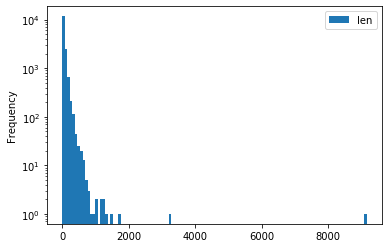

In [42]:
df.plot.hist(by='len', bins=120, log=True)

In [18]:
len_stat = t2t_problem.dataset(Modes.TRAIN, DATA_DIR).map(lambda x: tf.shape(x["inputs"])).padded_batch(10, padded_shapes=(1,))
train_df = pd.DataFrame() # {'len'}

for elem in len_stat:
    train_df = pd.concat([train_df, pd.DataFrame(elem.numpy()[0])], sort=False, copy=False, ignore_index=True)
    #print(elem.numpy())

INFO:tensorflow:Reading data files from /devfest/repos/name-suggestion/data/programming_function_name-train*


INFO:tensorflow:Reading data files from /devfest/repos/name-suggestion/data/programming_function_name-train*


INFO:tensorflow:partition: 0 num_data_files: 10


INFO:tensorflow:partition: 0 num_data_files: 10


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fef13285518>]],
      dtype=object)

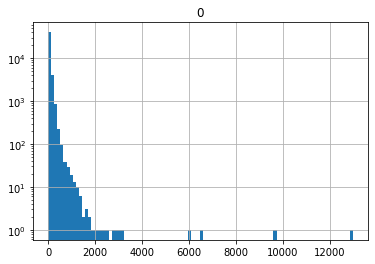

In [39]:
%matplotlib inline

train_df.hist(bins=100, log=True)

In [5]:
# Use the encoders to decode the tensors to the actual input text.
input_encoder = t2t_problem.get_feature_encoders(
    data_dir=DATA_DIR)["inputs"]
target_encoder = t2t_problem.get_feature_encoders(
    data_dir=DATA_DIR)["targets"]

input_decoded = input_encoder.decode(input_tensor.numpy())
target_decoded = target_encoder.decode(target_tensor.numpy())

print("Decoded Input: " + input_decoded)
print("Decoded Target: " + target_decoded)

Decoded Input: @ Override public Long del ( byte [ ] ... keys )<EOS>
Decoded Target: del<EOS>


In [15]:
input_encoder.encode("System . out")

[1525, 2, 19, 560]

In [14]:
import numpy as np
input_encoder.decode(np.array([1525, 2, 296, 560]))

'System.out'

## Train the model

In [ ]:
MODEL = "transformer"
HPARAMS = "transformer_small"

TRAIN_DIR="/devfest/repos/name-suggestion/model"

hparams = trainer_lib.create_hparams(HPARAMS)

# TODO: 
# - train on colab GPU (transformer .max_length=256, transformer_base_single_gpu batch_size=1024)
# - train on colab TPU (transformer .max_length=64,  transformer_tpu             batch_size=2048)
#   and compare results to '_packed' version
    

In [ ]:
save_checkpoints_steps=100
train_steps=1000
eval_steps=1000

RUN_CONFIG = create_run_config(
      model_dir=TRAIN_DIR,
      model_name=MODEL,
      save_checkpoints_steps=save_checkpoints_steps
)


In [ ]:
tensorflow_exp_fn = create_experiment(
        run_config=RUN_CONFIG,
        hparams=hparams,
        model_name=MODEL,
        problem_name=PROBLEM,
        data_dir=DATA_DIR, 
        train_steps=train_steps, 
        eval_steps=eval_steps, 
        #use_xla=True # For acceleration
    ) 

tensorflow_exp_fn.train_and_evaluate()


# restore from checkpoint
#model = registry.model(model_name)(hparams, Modes.EVAL)



## Visualize training

In [ ]:
# TODO: tensorboard (+tf2.0 on collab)

## Inference using trained model

In [ ]:
# TODO: infer + beam search

## Visualize the attention

In [ ]:
# TODO: HTML snippet

## Interactive predictions (local)

In [ ]:
# TODO: build and setup the inspector

## Compare the results

In [77]:
# TODO:
# - list all papers that use this task (Miltos, code2vec/seq, embeddings eval)
# - use same metric to evaluate (BLUE?)
# - identify current SotA

## Change task to Search (advanced)

In [ ]:
# TODO: using the same dataset, override problem, prepare the data (using same vocab)